In [14]:
import phaseco as pc
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib widget
fn = "Data/testV7gamma2.0.wf1.npz"
fs= 10000  #
loadData = np.load(fn)
wf= loadData['arr_0']
f0 = 500

Calculating Colossogram:


100%|██████████| 100/100 [00:02<00:00, 44.49it/s]


No peaks found in first 260ms of xi, starting fit at first xi!
Signal at 498Hz never decays!
Fitting exp decay to 498Hz peak


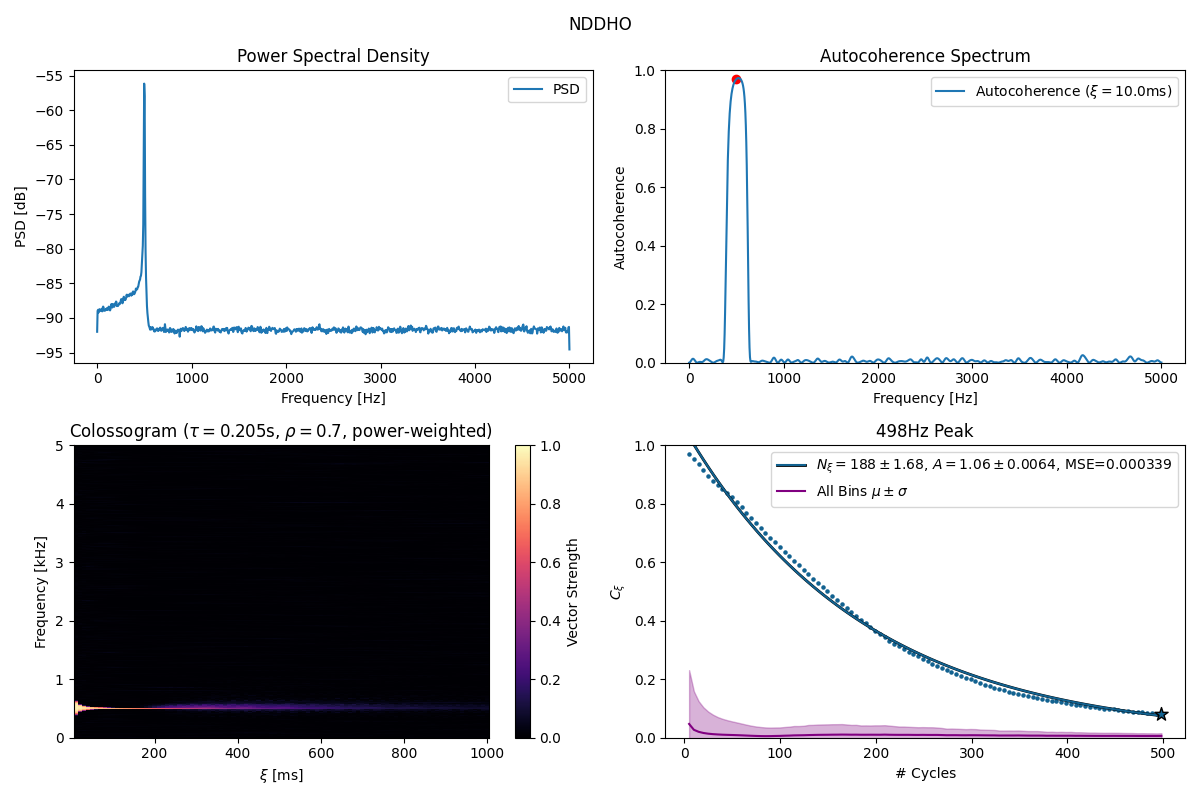

In [21]:
"Initialize Plot"
plt.figure(figsize=(12, 8))
plt.clf()

"Get Welch-averaged power spectral density"
# --- Parameters ---
tau = 2**11 # Length of each segment to FFT; power of two for max FFT performance
hop = tau // 2 # How much to hop between adjacent segments; tau // 2 = 50% overlap between segments
win = 'hann' # Hann window
scaling = 'density' # Power spectral density scaling

# Convert parameters in samples (unitless) to units of seconds
tau_s = tau / fs

# Calculate psd
f, psd = pc.get_welch(wf, fs, tau, hop=hop, win=win, scaling=scaling)

# Convert to log "dB" scale (technically not dB since no reference point)
psd_log = 10*np.log10(psd)

# Plot
plt.subplot(2, 2, 1)
plt.title("Power Spectral Density")
plt.plot(f, psd_log, label='PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.legend()

"Get phase coherence spectrum"
# --- Parameters ---

pw = True
# pw (power weights) controls whether we weight each phase diff in the vector strength complex average by weights given by:
# weight = (magnitude of segment at this freq) * (magnitude of the xi-advanced segment at this freq)
# This is equivalent to the classical coherence signal processing measure between the signal and a xi-advanced shifted copy of the signal (e.g. Zhou and Dagle)

# Define the phase reference distance xi
xi_s = 0.01 # This one I like to define in seconds (that's the _s) and then convert to samples later

# Windowing method; see get_win_pc() documentation for details 
dyn_win_meth = 'rho'
rho = 0.7
win_meth = {'method':dyn_win_meth, 'rho':rho} 

# Phase reference type
ref_type = 'next_seg' # This means we reference the phase to the next segment AKA C_xi
# other option is 'next_freq' for neighboring freq bin AKA C_omega 

# Convert to samples
xi = round(xi_s * fs)

# Calculate coherence of waveform with itself
f, acoh = pc.get_autocoherence(wf, fs, xi, pw, tau, hop=hop, win_meth=win_meth, ref_type=ref_type)

# Plot
plt.subplot(2, 2, 2)
plt.title("Autocoherence Spectrum")
plt.plot(f, acoh, label=rf'Autocoherence ($\xi={xi_s*1000:.1f}$ms)')
# Get the frequency bin of interest and mark it
f0_idx = np.argmin(np.abs(f-f0))
plt.scatter(f[f0_idx], acoh[f0_idx], color='red')
plt.ylim(0, 1)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Autocoherence")
plt.legend()


"Get Colossogram"
# This is a series of autocoherences, one for each xi value, showing how the coherence falls off with increasing reference distance

# --- Parameters ---
xis = {
    'xi_min_s' : 0.01,
    'xi_max_s' : 1.0,
    'delta_xi_s' : 0.01,
} 
# the xis parameter can be dict like this to create evenly spaced array from xi_min to xi_max with step delta_xi (can be passed in samples or seconds)
# ...or it can just be the array of desired xi values (in samples)

# Calculate colossogram
print("Calculating Colossogram:")
xis_s, f, colossogram = pc.get_colossogram(wf, fs, xis, pw, tau, hop=hop, win_meth=win_meth)

# Plot colossogram
plt.subplot(2, 2, 3)
pc.plot_colossogram(xis_s, f, colossogram)
plt.title(rf"Colossogram ($\tau={tau_s:.3f}$s, $\rho={rho}$, power-weighted)")

# Extract N_xi
N_xi, fit_dict = pc.get_N_xi(xis_s, f, colossogram, f0)

plt.subplot(2, 2, 4)
pc.plot_N_xi_fit(fit_dict)


# Wrap it up
plt.suptitle("NDDHO")
plt.tight_layout()
plt.show()